# Preliminary operations

We import the libraries and extract the zip file into the Colab environment.

In [2]:
# Utility
from google.colab import drive
from shutil import copyfile, copy
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import itertools

# Audio processing
import librosa
import librosa.display
import audiomentations

# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Keras
import keras
from keras import regularizers
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, Activation, LeakyReLU, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

2023-06-13 20:41:02.095355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data exploration

Each filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers represent:

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong (not for neutral emotion)). 
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [5]:
dir_list = os.listdir('./Datasets/AUDIO/')
dir_list.sort()
dir_list

['Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']

In [16]:
count = [0] * 6
j = 0
for i in dir_list:
  filename = os.listdir('./Datasets/AUDIO/' + i)
  for f in filename:
    if f.endswith('wav'): 
      count[j]+=1
  j+=1

count

24 subjects, each with 60 audio files.

Now let's divide the audio files according to their labels. We don't consider the neutral emotion because of two reasons: it has half the data then the other emotions and it's very similar to the calm emotion. We have found that the network cannot distinguish neutral class.

In [18]:
def switch(emotion):
  if emotion == 2:
    return 'calm'
  elif emotion == 3:
    return 'happy'
  elif emotion == 4:
    return 'sad'
  elif emotion == 5:
    return 'angry'
  elif emotion == 6:
    return 'fear'
  elif emotion == 7:
    return 'disgust'
  elif emotion == 8:
    return 'surprise'

In [28]:
emotion = []
path = []
for i in dir_list:
  filename = os.listdir('./Datasets/AUDIO/' + i)
  for f in filename:
    # Remove wav extension
    id = f[:-4].split('-')
    if(id[2] != '01'):
      # Dividing according to emotions
      emotion.append(switch(int(id[2])))
      path.append('./Datasets/AUDIO/' + i + '/' + f)

In [29]:
df = pd.concat([pd.DataFrame(emotion), pd.DataFrame(path)], axis = 1)
df.columns = ['emotion', 'path']
df['emotion'].value_counts()

sad         192
disgust     192
angry       192
happy       192
surprise    192
fear        192
calm        192
Name: emotion, dtype: int64

In [32]:
for i in df['path']:
    if not os.path.exists(i):
        print(f"{i.split('/')[-1]} is not exists ")

The dataset is perfectly balanced.

Let's pick some tracks.

We can already notice a few things:
*   The duration is about 4 seconds.
*   There are some moments of silence at the beginning and at the end. We may remove them by picking just the central seconds.

Now, let's check the duration and the sampling rate for each statement.

In [ ]:
duration = []
rate = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000) # We want the native sr
  duration.append(data.shape[0])
  rate.append(sampling_rate)
print(np.unique(duration))
print(np.unique(rate))

The rate is the same for each sample. Let's have a better view of the durations.

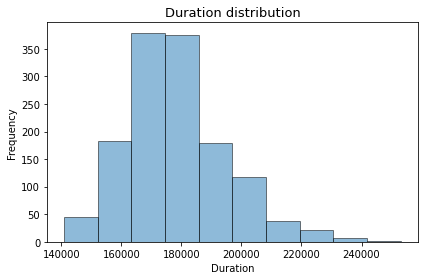

In [ ]:
plt.title('Duration distribution', fontsize = 13)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.hist(duration, alpha = 0.5, histtype = 'bar', ec = 'black')
plt.tight_layout()
plt.show() 

Duration in seconds = duration / 48000 (sample rate).

In [ ]:
print(round(np.mean(duration), 2))
print(np.min(duration))
print(np.max(duration))

178309.1
140941
253053


Seems like we have a mean of ~180000 and a duration span of ~45000.

# Data processing

First of all, we cut the first and the last part of each sample in order to have a uniform duration of 3 seconds. 

In [ ]:
audio = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000, duration = 3, offset = 0.5) # We want the native sr
  audio.append(data)
df = pd.DataFrame(np.column_stack([df, audio]))
df.columns = ['emotion', 'path', 'data']

In [34]:
df.head()

,emotion,path,data
0,sad,./Datasets/AUDIO/Actor_19/01-01-04-02-01-02-19...,"[-2.8616792e-05, -3.3365617e-05, -2.7662885e-0..."
1,disgust,./Datasets/AUDIO/Actor_19/02-01-07-01-01-01-19...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,sad,./Datasets/AUDIO/Actor_19/02-01-04-02-02-01-19...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,disgust,./Datasets/AUDIO/Actor_19/01-01-07-02-01-01-19...,"[-2.9247818e-05, -3.2468255e-05, -2.86569e-05,..."
4,angry,./Datasets/AUDIO/Actor_19/01-01-05-02-02-01-19...,"[-0.00086480106, -0.0008680711, 0.00015216427,..."


We pad with zeros the audio with length < 144000.

In [35]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    start_pad = (144000 - len(df['data'][i]))//2
    end_pad = 144000 - len(df['data'][i]) - start_pad
    df['data'][i] = np.pad(df['data'][i], (start_pad, end_pad), mode = 'constant')

In [36]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    print(len(df['data'][i]))

## Feature extraction

We extract the log Mel spectrogram.

Let's see an example.

/tmp/ipykernel_78519/3864085772.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))


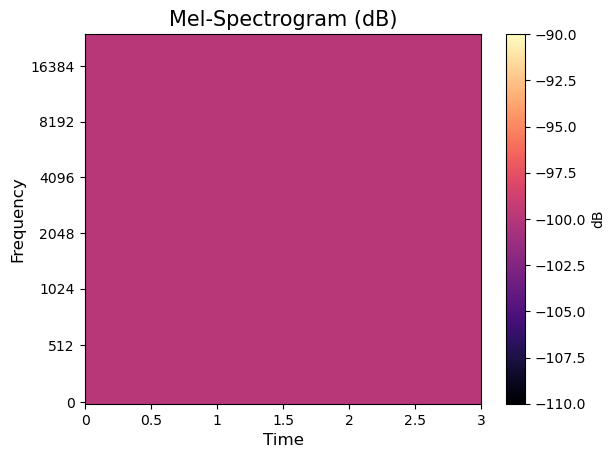

In [37]:
mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 
plt.figure()
librosa.display.specshow(mel, sr = 48000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
plt.colorbar(label = 'dB')
plt.title('Mel-Spectrogram (dB)', fontdict = dict(size = 15))
plt.xlabel('Time', fontdict = dict(size = 12))
plt.ylabel('Frequency', fontdict = dict(size = 12))
plt.show()

In [38]:
def feature_extractor(input, feature, sr = 48000):
  # Mel Spectrogram
  if(feature == 'mel'):
    return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 

In [ ]:
df['features'] = [0] * 1344
for i in range(len(df)):
  mel = feature_extractor(df['data'][i], 'mel')
  df['features'][i] = np.array(mel, dtype = object)

We already split the dataset into training and test, in order to perform augmentation only on the training set. We use actors 21-24 for test.

In [40]:
X_test = df['features'][1120:1344].tolist()
y_test = df['emotion'][1120:1344].tolist()

In [41]:
X_train = df['features'][:1120].tolist()
y_train = df['emotion'][:1120].tolist()

## Data augmentation

This phase is performed in the following way;
1.   We add noise for all the signals.
2.   We pitch all the signals.
3.   We stretch all the signals.
4.   We shift all the signals.

In the end, we'll have the following data:
*   Original dataset.
*   Noise dataset.
*   Pitch dataset.
*   Stretch dataset.
*   Shift dataset.

### Noise

In [42]:
noise = audiomentations.Compose([
    audiomentations.AddGaussianNoise(p = 1)
])

In [ ]:
for i in range(1120):
  augmented_samples = noise(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

### Pitch

In [44]:
pitchShift = audiomentations.Compose([
    audiomentations.PitchShift(p = 1)
])

In [ ]:
for i in range(1120):
  augmented_samples = pitchShift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

### Stretch

In [46]:
stretch = audiomentations.Compose([
    audiomentations.TimeStretch(p = 1)
])

In [ ]:
for i in range(1120):
  augmented_samples = stretch(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

### Shift

In [48]:
shift = audiomentations.Compose([
    audiomentations.Shift(min_fraction = 0.25, max_fraction = 0.25, rollover = False, p = 1)
])

In [ ]:
for i in range(1120):  
  augmented_samples = shift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

In [50]:
print('We obtained ' + str(len(X_train)) + ' samples.')

We obtained 5600 samples.


## Split train-test

We load and normalize the data.

In [51]:
for i in range(len(X_train)):
  X_train[i] = X_train[i].astype(np.float64)
for i in range(len(X_test)):
  X_test[i] = X_test[i].astype(np.float64)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

scaler_train = StandardScaler()

X_train[:1120] = scaler_train.fit_transform(X_train[:1120].reshape(-1, X_train.shape[-1])).reshape(X_train[:1120].shape)
X_train[1120:] = scaler_train.transform(X_train[1120:].reshape(-1, X_train.shape[-1])).reshape(X_train[1120:].shape)
X_test = scaler_train.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Saving scaler for demo purpose.

In [52]:
joblib.dump(scaler_train, './Datasets/std_scaler.bin')

['./Datasets/std_scaler.bin']

In [53]:
# One-hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [54]:
# Making data compatible for the model
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5600, 128, 282, 1), (5600, 7), (224, 128, 282, 1), (224, 7))

Saving test data for demo purpose.

In [56]:
np.save('./Datasets/X_test', X_test)
np.save('./Datasets/y_test', y_test)

In [57]:
df = 0

# Model selection

We instanciate our first model with 3 Conv2D layers, 2 Dense layers, ReLU activations and MaxPooling2D. The output will be provided by the softmax function.

## Model 0: vanilla data

In this preliminary model we use the data "vanilla" (i.e. not augmented).

In [58]:
X_train_vanilla = X_train[:896]
y_train_vanilla = y_train[:896]
X_val = X_train[896:1120]
y_val = y_train[896:1120]
X_train_vanilla.shape, y_train_vanilla.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((896, 128, 282, 1),
 (896, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [59]:
num_classes = 7

model0 = Sequential()

model0.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(GlobalMaxPooling2D())

model0.add(Dense(64, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 140, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 67, 64)        36928     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0

2023-06-13 21:35:15.549573: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [60]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [61]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/100
28/28 [==============================] - 7s 245ms/step - loss: 1.9373 - accuracy: 0.1540 - val_loss: 1.9415 - val_accuracy: 0.1607
Epoch 2/100
28/28 [==============================] - 7s 234ms/step - loss: 1.8836 - accuracy: 0.2031 - val_loss: 1.8952 - val_accuracy: 0.1830
Epoch 3/100
28/28 [==============================] - 7s 236ms/step - loss: 1.8406 - accuracy: 0.2232 - val_loss: 1.8552 - val_accuracy: 0.2143
Epoch 4/100
28/28 [==============================] - 7s 235ms/step - loss: 1.7940 - accuracy: 0.2511 - val_loss: 1.8690 - val_accuracy: 0.2768
Epoch 5/100
28/28 [==============================] - 7s 238ms/step - loss: 1.8007 - accuracy: 0.2556 - val_loss: 1.8392 - val_accuracy: 0.2411
Epoch 6/100
28/28 [==============================] - 7s 237ms/step - loss: 1.7402 - accuracy: 0.2734 - val_loss: 1.8420 - val_accuracy: 0.2188
Epoch 7/100
28/28 [==============================] - 7s 243ms/step - loss: 1.7330 - accuracy: 0.2868 - val_loss: 1.8087 - val_accuracy: 0.2321

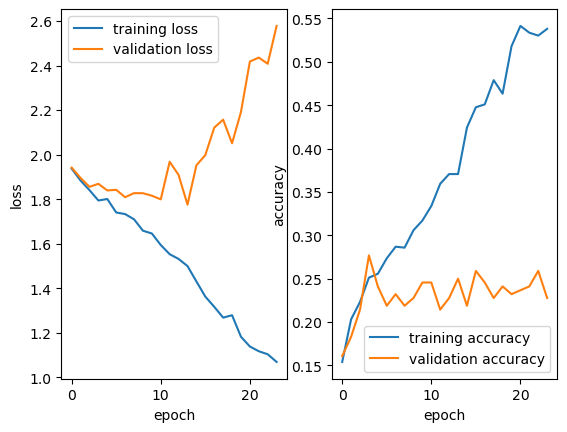

In [62]:
plt.subplot(1,2,1)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [63]:
y_pred = model0.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 47ms/step
              precision    recall  f1-score   support

           0       0.47      0.22      0.30        32
           1       0.29      0.12      0.17        32
           2       0.58      0.47      0.52        32
           3       0.18      0.06      0.09        32
           4       0.00      0.00      0.00        32
           5       0.18      0.06      0.09        32
           6       0.18      0.81      0.30        32

    accuracy                           0.25       224
   macro avg       0.27      0.25      0.21       224
weighted avg       0.27      0.25      0.21       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

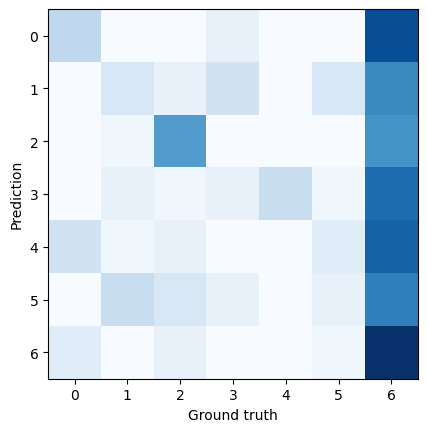

In [64]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [65]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.42857142857142855
0.5758928571428571


## Grid search CV

Now we can perform a grid search on various hyperparameters. In particular, this search is performed on the basis of a 5-Folds Cross-Validation. For each fold, the validation set is composed by 4 different actors.

In [66]:
alpha = [0.00, 0.01]
dropout = [0.2, 0.4]
k_reg = [0.01, 0.001]
b_reg = [0.01, 0.001]

params = [{'alpha': item[0],
           'dropout': item[1],
           'k_reg': item[2],
           'b_reg': item[3]
            } for item in
              list(itertools.product(*[alpha,
                                       dropout,
                                       k_reg,
                                       b_reg]))
          ]

In [67]:
# Splitting dataset into 5 folds
X_train_CV = []
y_train_CV = []
X_val_CV= []
y_val_CV = []
X_train_ = np.concatenate((X_train_vanilla, X_val), axis = 0)
y_train_ = np.concatenate((y_train_vanilla, y_val), axis = 0)
for i in range(0, 5):
  start = i*4*56
  end = start + 224
  index =  list(range(start, end))
  X_val_CV.append(X_train_[start:end])
  y_val_CV.append(y_train_[start:end])
  X_train_CV.append(np.concatenate((X_train_[0:start], X_train_[end:1120]), axis = 0))
  y_train_CV.append(np.concatenate((y_train_[0:start], y_train_[end:1120]), axis = 0))

In [68]:
for i in X_train_CV:
  print(i.shape)

(896, 128, 282, 1)
(896, 128, 282, 1)
(896, 128, 282, 1)
(896, 128, 282, 1)
(896, 128, 282, 1)


In [69]:
results = []
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
for param in params:
  score1 = []
  score2 = []
  score3 = []
  for i in range(5):
    num_classes = 7

    modelCV = Sequential()

    modelCV.add(Conv2D(32, (3, 3), input_shape = (128, 282, 1)))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(MaxPooling2D((2, 2)))

    modelCV.add(Conv2D(64, (3, 3), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(MaxPooling2D((2, 2)))
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Conv2D(64, (3, 3), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(GlobalMaxPooling2D())
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Dense(64, kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Dense(num_classes, activation = 'softmax'))

    modelCV.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
    historyCV = modelCV.fit(X_train_CV[i], y_train_CV[i], batch_size = 32, epochs = 75, validation_data = (X_val_CV[i], y_val_CV[i]), callbacks = [stop_early], verbose = 0)
    
    res = modelCV.evaluate(X_val_CV[i], y_val_CV[i], verbose = 0)
    score1.append(res[0])
    score2.append(res[1])
    y_pred = modelCV.predict(X_val_CV[i], verbose = 0)
    y_val_ = np.argmax(y_val_CV[i], axis = 1)
    score3.append(top_k_accuracy_score(y_val_, y_pred, k = 3))

  results.append([str(param) + ' ' + str(np.around(np.mean(score1), 3)) + ' ' + str(np.around(np.mean(score2), 3)) + ' ' + str(np.around(np.mean(score3), 3))])

KeyboardInterrupt: 

In [ ]:
results

Seems like the best model has the following hyperparameters:

* alpha: 0.0,
* dropout: 0.2,
* k_reg: 0.001,
* b_reg: 0.01.

Best loss: 1.415.
Top-1 accuracy: 50.5%.
Top-3 accuracy: 83.3%

Let's build this model.

## Model 1: fine-tuned

In [ ]:
num_classes = 7

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(GlobalMaxPooling2D())
model1.add(Dropout(0.2))

model1.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(Dropout(0.2))

model1.add(Dense(num_classes, activation = 'softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 140, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 69, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 67, 64)       

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
28/28 [==============================] - 2s 48ms/step - loss: 2.1181 - accuracy: 0.1618 - val_loss: 2.0515 - val_accuracy: 0.1875
Epoch 2/200
28/28 [==============================] - 1s 37ms/step - loss: 2.0296 - accuracy: 0.2065 - val_loss: 1.9915 - val_accuracy: 0.2634
Epoch 3/200
28/28 [==============================] - 1s 37ms/step - loss: 1.9815 - accuracy: 0.2467 - val_loss: 1.9809 - val_accuracy: 0.1920
Epoch 4/200
28/28 [==============================] - 1s 37ms/step - loss: 1.9489 - accuracy: 0.2333 - val_loss: 1.9226 - val_accuracy: 0.2455
Epoch 5/200
28/28 [==============================] - 1s 37ms/step - loss: 1.9197 - accuracy: 0.2333 - val_loss: 1.9170 - val_accuracy: 0.2812
Epoch 6/200
28/28 [==============================] - 1s 39ms/step - loss: 1.8987 - accuracy: 0.2388 - val_loss: 1.8717 - val_accuracy: 0.2857
Epoch 7/200
28/28 [==============================] - 1s 39ms/step - loss: 1.8733 - accuracy: 0.2511 - val_loss: 1.8603 - val_accuracy: 0.2991
Epoch 

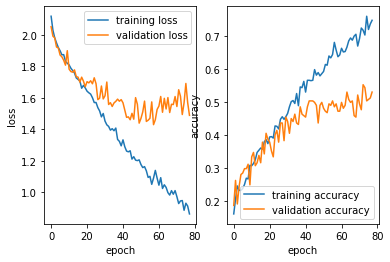

In [ ]:
plt.subplot(1,2,1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model1.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.38      0.50      0.43        32
           1       0.69      0.84      0.76        32
           2       0.68      0.72      0.70        32
           3       0.31      0.34      0.33        32
           4       0.40      0.19      0.26        32
           5       0.27      0.28      0.28        32
           6       0.73      0.59      0.66        32

    accuracy                           0.50       224
   macro avg       0.50      0.50      0.49       224
weighted avg       0.50      0.50      0.49       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

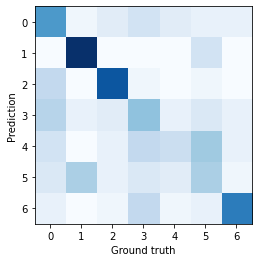

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7366071428571429
0.84375


## Model 2: augmented data

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

Now let's return to the original model and compare the performances if we use augmented data.

In [ ]:
num_classes = 7

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(GlobalMaxPooling2D())

model2.add(Dense(64, activation = 'relu'))

model2.add(Dense(num_classes, activation = 'softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 140, 32)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 67, 64)        36928     
                                                                 
 global_max_pooling2d_2 (Glo  (None, 64)              

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/100
140/140 [==============================] - 5s 35ms/step - loss: 1.8548 - accuracy: 0.2252 - val_loss: 1.7788 - val_accuracy: 0.2411
Epoch 2/100
140/140 [==============================] - 5s 34ms/step - loss: 1.7527 - accuracy: 0.2853 - val_loss: 1.7532 - val_accuracy: 0.2768
Epoch 3/100
140/140 [==============================] - 5s 33ms/step - loss: 1.6706 - accuracy: 0.3286 - val_loss: 1.6808 - val_accuracy: 0.3259
Epoch 4/100
140/140 [==============================] - 5s 33ms/step - loss: 1.6070 - accuracy: 0.3663 - val_loss: 1.6398 - val_accuracy: 0.3438
Epoch 5/100
140/140 [==============================] - 5s 34ms/step - loss: 1.4974 - accuracy: 0.4234 - val_loss: 1.5543 - val_accuracy: 0.3973
Epoch 6/100
140/140 [==============================] - 5s 33ms/step - loss: 1.3892 - accuracy: 0.4681 - val_loss: 1.5050 - val_accuracy: 0.4375
Epoch 7/100
140/140 [==============================] - 5s 34ms/step - loss: 1.2660 - accuracy: 0.5105 - val_loss: 1.5789 - val_accuracy:

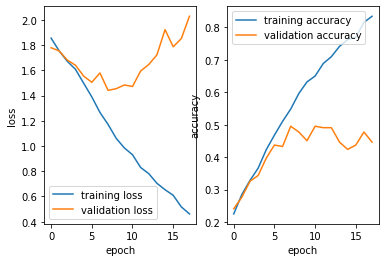

In [ ]:
plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model2.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        32
           1       0.59      0.72      0.65        32
           2       0.64      0.72      0.68        32
           3       0.40      0.53      0.46        32
           4       0.26      0.28      0.27        32
           5       0.19      0.09      0.12        32
           6       0.62      0.56      0.59        32

    accuracy                           0.50       224
   macro avg       0.48      0.50      0.48       224
weighted avg       0.48      0.50      0.48       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

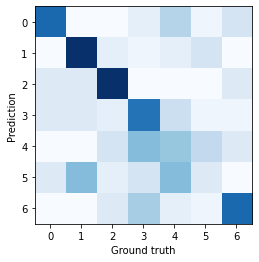

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7053571428571429
0.7991071428571429


## Model 3: fine-tuned aug

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

Due to insufficient RAM, we use the parameters found above in Grid Search CV.

In [ ]:
num_classes = 7

model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(GlobalMaxPooling2D())
model3.add(Dropout(0.2))

model3.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(num_classes, activation = 'softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 140, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 69, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 67, 64)        3

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 14s 36ms/step - loss: 2.0350 - accuracy: 0.1984 - val_loss: 1.9523 - val_accuracy: 0.2455
Epoch 2/200
140/140 [==============================] - 5s 34ms/step - loss: 1.9373 - accuracy: 0.2377 - val_loss: 1.8953 - val_accuracy: 0.2991
Epoch 3/200
140/140 [==============================] - 5s 34ms/step - loss: 1.8610 - accuracy: 0.2714 - val_loss: 1.8401 - val_accuracy: 0.3214
Epoch 4/200
140/140 [==============================] - 5s 33ms/step - loss: 1.8279 - accuracy: 0.2978 - val_loss: 1.7858 - val_accuracy: 0.3527
Epoch 5/200
140/140 [==============================] - 5s 34ms/step - loss: 1.7945 - accuracy: 0.3089 - val_loss: 1.7567 - val_accuracy: 0.3393
Epoch 6/200
140/140 [==============================] - 5s 33ms/step - loss: 1.7606 - accuracy: 0.3185 - val_loss: 1.7490 - val_accuracy: 0.3348
Epoch 7/200
140/140 [==============================] - 5s 34ms/step - loss: 1.7358 - accuracy: 0.3306 - val_loss: 1.7290 - val_accuracy

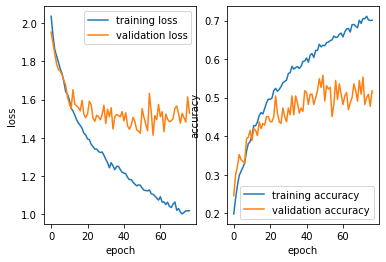

In [ ]:
plt.subplot(1,2,1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model3.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.41      0.47      0.43        32
           1       0.80      0.75      0.77        32
           2       0.55      0.72      0.62        32
           3       0.44      0.34      0.39        32
           4       0.40      0.38      0.39        32
           5       0.54      0.44      0.48        32
           6       0.68      0.72      0.70        32

    accuracy                           0.54       224
   macro avg       0.54      0.54      0.54       224
weighted avg       0.54      0.54      0.54       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

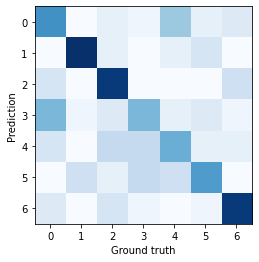

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7410714285714286
0.8705357142857143


## Model 3.1: double filters

We may try to double the number of filters for each layer.

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [ ]:
num_classes = 7

model31 = Sequential()

model31.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model31.add(MaxPooling2D((2, 2)))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(MaxPooling2D((2, 2)))
model31.add(Dropout(0.2))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(GlobalMaxPooling2D())
model31.add(Dropout(0.2))

model31.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(Dropout(0.2))

model31.add(Dense(num_classes, activation = 'softmax'))

model31.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 280, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 140, 64)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 138, 128)      73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 69, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 30, 69, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 67, 128)      

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model31.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history31 = model31.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 12s 72ms/step - loss: 2.1454 - accuracy: 0.2165 - val_loss: 1.9973 - val_accuracy: 0.2902
Epoch 2/200
140/140 [==============================] - 10s 69ms/step - loss: 1.9739 - accuracy: 0.2442 - val_loss: 1.9200 - val_accuracy: 0.2857
Epoch 3/200
140/140 [==============================] - 10s 70ms/step - loss: 1.9006 - accuracy: 0.2654 - val_loss: 1.8430 - val_accuracy: 0.2500
Epoch 4/200
140/140 [==============================] - 10s 70ms/step - loss: 1.8632 - accuracy: 0.2772 - val_loss: 1.8049 - val_accuracy: 0.3259
Epoch 5/200
140/140 [==============================] - 10s 70ms/step - loss: 1.8023 - accuracy: 0.3071 - val_loss: 1.7795 - val_accuracy: 0.3170
Epoch 6/200
140/140 [==============================] - 10s 70ms/step - loss: 1.7662 - accuracy: 0.3167 - val_loss: 1.7206 - val_accuracy: 0.3884
Epoch 7/200
140/140 [==============================] - 10s 71ms/step - loss: 1.7146 - accuracy: 0.3431 - val_loss: 1.6940 - val_ac

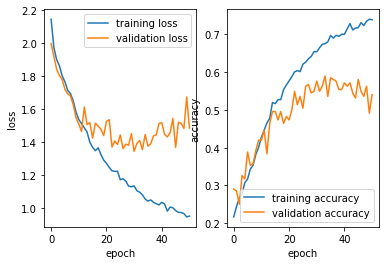

In [ ]:
plt.subplot(1,2,1)
plt.plot(history31.history['loss'])
plt.plot(history31.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history31.history['accuracy'])
plt.plot(history31.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model31.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        32
           1       0.76      0.78      0.77        32
           2       0.70      0.72      0.71        32
           3       0.61      0.53      0.57        32
           4       0.26      0.16      0.20        32
           5       0.51      0.69      0.59        32
           6       0.57      0.66      0.61        32

    accuracy                           0.58       224
   macro avg       0.56      0.58      0.56       224
weighted avg       0.56      0.58      0.56       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

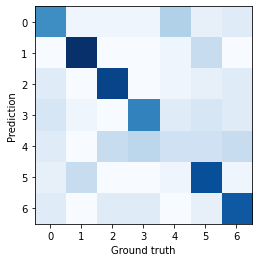

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7723214285714286
0.8794642857142857


## Model 3.2: rectangular kernel

We may try to change the kernel size to a rectangular shape, due to the rectangular shape of the mel spectrograms.

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [ ]:
num_classes = 7

model32 = Sequential()

model32.add(Conv2D(64, (3, 5), activation = 'relu', input_shape = (128, 282, 1)))
model32.add(MaxPooling2D((2, 2)))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(MaxPooling2D((2, 2)))
model32.add(Dropout(0.2))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(GlobalMaxPooling2D())
model32.add(Dropout(0.2))

model32.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(Dropout(0.2))

model32.add(Dense(num_classes, activation = 'softmax'))

model32.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 278, 64)      1024      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 139, 64)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 135, 128)      123008    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 67, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 30, 67, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 63, 128)      

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model32.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history32 = model32.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 14s 90ms/step - loss: 2.1303 - accuracy: 0.2167 - val_loss: 1.9732 - val_accuracy: 0.2634
Epoch 2/200
140/140 [==============================] - 12s 88ms/step - loss: 1.9672 - accuracy: 0.2252 - val_loss: 1.8992 - val_accuracy: 0.2857
Epoch 3/200
140/140 [==============================] - 12s 88ms/step - loss: 1.8826 - accuracy: 0.2694 - val_loss: 1.8535 - val_accuracy: 0.2902
Epoch 4/200
140/140 [==============================] - 12s 88ms/step - loss: 1.8261 - accuracy: 0.2859 - val_loss: 1.7905 - val_accuracy: 0.3214
Epoch 5/200
140/140 [==============================] - 12s 89ms/step - loss: 1.7729 - accuracy: 0.3107 - val_loss: 1.7380 - val_accuracy: 0.3393
Epoch 6/200
140/140 [==============================] - 12s 89ms/step - loss: 1.7338 - accuracy: 0.3259 - val_loss: 1.7047 - val_accuracy: 0.3616
Epoch 7/200
140/140 [==============================] - 12s 89ms/step - loss: 1.6437 - accuracy: 0.3775 - val_loss: 1.6417 - val_ac

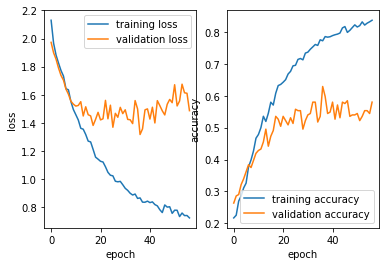

In [ ]:
plt.subplot(1,2,1)
plt.plot(history32.history['loss'])
plt.plot(history32.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history32.history['accuracy'])
plt.plot(history32.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model32.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 35ms/step
              precision    recall  f1-score   support

           0       0.72      0.41      0.52        32
           1       0.71      0.78      0.75        32
           2       0.76      0.91      0.83        32
           3       0.68      0.66      0.67        32
           4       0.42      0.56      0.48        32
           5       0.43      0.38      0.40        32
           6       0.74      0.72      0.73        32

    accuracy                           0.63       224
   macro avg       0.64      0.63      0.62       224
weighted avg       0.64      0.63      0.62       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

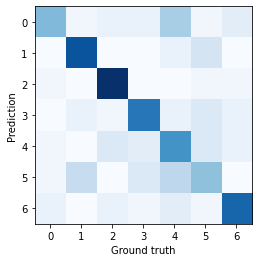

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.8080357142857143
0.9107142857142857


# Saving and testing

Now we may merge training set and validation set in order to re-train all of our models on a bigger set of data. Then, we'll test the performances on the test set.

## Model 0

In [ ]:
X_train_vanilla = X_train[:1120]
y_train_vanilla = y_train[:1120]

In [ ]:
num_classes = 7

model0 = Sequential()

model0.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(GlobalMaxPooling2D())

model0.add(Dense(64, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 30, verbose = 0)

In [ ]:
y_pred = model0.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.35      0.62      0.45        32
           1       0.50      0.12      0.20        32
           2       0.64      0.56      0.60        32
           3       0.31      0.28      0.30        32
           4       0.28      0.28      0.28        32
           5       0.33      0.50      0.40        32
           6       0.62      0.41      0.49        32

    accuracy                           0.40       224
   macro avg       0.43      0.40      0.39       224
weighted avg       0.43      0.40      0.39       224



Text(0, 0.5, 'Prediction')

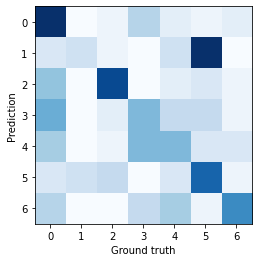

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.625
0.78125


In [ ]:
model0.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model0.h5')

## Model 1

In [ ]:
num_classes = 7

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(GlobalMaxPooling2D())
model1.add(Dropout(0.2))

model1.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(Dropout(0.2))

model1.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 70, verbose = 0)

In [ ]:
y_pred = model1.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        32
           1       0.61      0.53      0.57        32
           2       0.45      0.84      0.59        32
           3       0.44      0.34      0.39        32
           4       0.21      0.12      0.16        32
           5       0.27      0.09      0.14        32
           6       0.72      0.81      0.76        32

    accuracy                           0.49       224
   macro avg       0.46      0.49      0.45       224
weighted avg       0.46      0.49      0.45       224



Text(0, 0.5, 'Prediction')

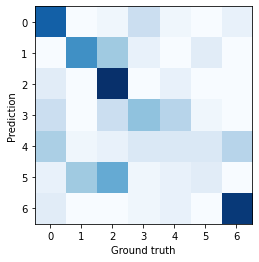

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.7232142857142857
0.8080357142857143


In [ ]:
model1.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model1.h5')

## Model 2

In [ ]:
num_classes = 7

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(GlobalMaxPooling2D())

model2.add(Dense(64, activation = 'relu'))

model2.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 15, verbose = 0)

In [ ]:
y_pred = model2.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.43      0.84      0.57        32
           1       0.55      0.56      0.55        32
           2       0.40      0.72      0.52        32
           3       0.58      0.22      0.32        32
           4       0.42      0.16      0.23        32
           5       0.40      0.12      0.19        32
           6       0.70      0.81      0.75        32

    accuracy                           0.49       224
   macro avg       0.50      0.49      0.45       224
weighted avg       0.50      0.49      0.45       224



Text(0, 0.5, 'Prediction')

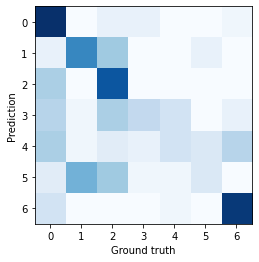

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.7053571428571429
0.84375


In [ ]:
model2.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model2.h5')

## Model 3

In [ ]:
num_classes = 7

model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(GlobalMaxPooling2D())
model3.add(Dropout(0.2))

model3.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 70, verbose = 0)

In [ ]:
y_pred = model3.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        32
           1       0.55      0.69      0.61        32
           2       0.60      0.88      0.71        32
           3       1.00      0.22      0.36        32
           4       0.41      0.22      0.29        32
           5       0.30      0.28      0.29        32
           6       0.68      1.00      0.81        32

    accuracy                           0.57       224
   macro avg       0.59      0.57      0.53       224
weighted avg       0.59      0.57      0.53       224



Text(0, 0.5, 'Prediction')

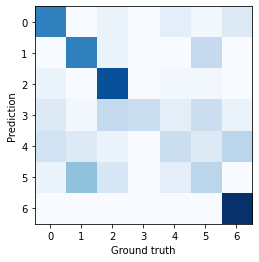

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.75
0.8660714285714286


In [ ]:
model3.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model3.h5')

## Model 3.1

In [77]:
num_classes = 7

model31 = Sequential()

model31.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model31.add(MaxPooling2D((2, 2)))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(MaxPooling2D((2, 2)))
model31.add(Dropout(0.2))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(GlobalMaxPooling2D())
model31.add(Dropout(0.2))

model31.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(Dropout(0.2))

model31.add(Dense(num_classes, activation = 'softmax'))

In [78]:
model31.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history31 = model31.fit(X_train, y_train, batch_size = 32, epochs = 40, verbose = 0)

In [ ]:
y_pred = model31.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

           0       0.63      0.38      0.47        32
           1       0.52      0.97      0.67        32
           2       0.64      0.91      0.75        32
           3       0.62      0.25      0.36        32
           4       0.35      0.28      0.31        32
           5       0.24      0.16      0.19        32
           6       0.78      0.97      0.86        32

    accuracy                           0.56       224
   macro avg       0.54      0.56      0.52       224
weighted avg       0.54      0.56      0.52       224



Text(0, 0.5, 'Prediction')

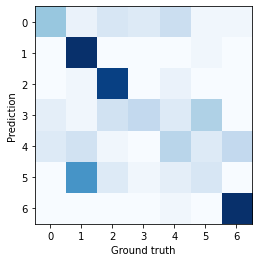

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.8080357142857143
0.9017857142857143


In [ ]:
model31.save('./Models/Audio Stream/Audio_CNN 2D/model3_1.h5')

## Model 3.2

In [70]:
num_classes = 7

model32 = Sequential()

model32.add(Conv2D(64, (3, 5), activation = 'relu', input_shape = (128, 282, 1)))
model32.add(MaxPooling2D((2, 2)))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(MaxPooling2D((2, 2)))
model32.add(Dropout(0.2))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(GlobalMaxPooling2D())
model32.add(Dropout(0.2))

model32.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(Dropout(0.2))

model32.add(Dense(num_classes, activation = 'softmax'))

In [71]:
model32.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history32 = model32.fit(X_train, y_train, batch_size = 32, epochs = 45, verbose = 0) 

In [72]:
y_pred = model32.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 2s 279ms/step
              precision    recall  f1-score   support

           0       0.67      0.12      0.21        32
           1       0.19      0.75      0.31        32
           2       0.33      0.06      0.11        32
           3       0.29      0.31      0.30        32
           4       0.31      0.28      0.30        32
           5       0.40      0.12      0.19        32
           6       0.27      0.12      0.17        32

    accuracy                           0.25       224
   macro avg       0.35      0.25      0.23       224
weighted avg       0.35      0.25      0.23       224



Text(0, 0.5, 'Prediction')

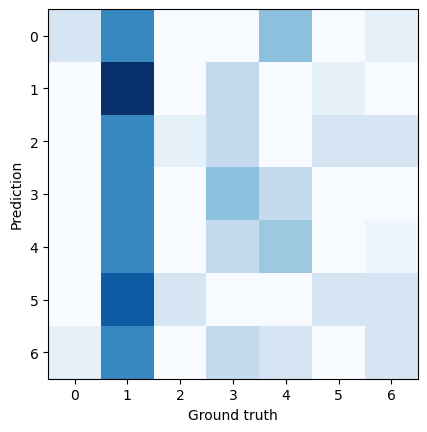

In [73]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [74]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.41964285714285715
0.5625


In [75]:
model32.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model3_2.h5')

PermissionDeniedError: /content; Permission denied

In [76]:
model32.save('./Models/Audio Stream/Audio_CNN 2D/model3_2.h5')